In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_array
from scipy.sparse.csgraph import dijkstra

In [2]:
%load_ext autoreload
%autoreload 2

In [83]:
from functions import static_assignment_fw
from functions import *
from plot import plot_network

<Axes: >

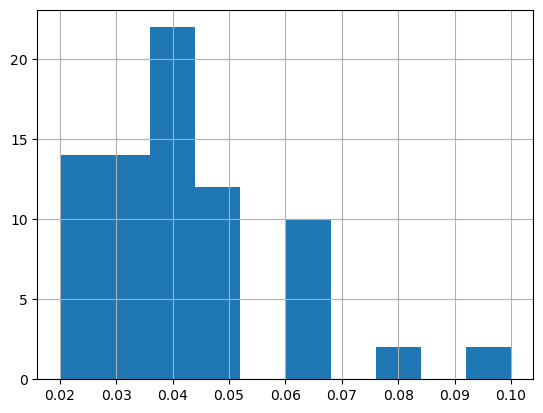

In [78]:
df_link.t0.hist()

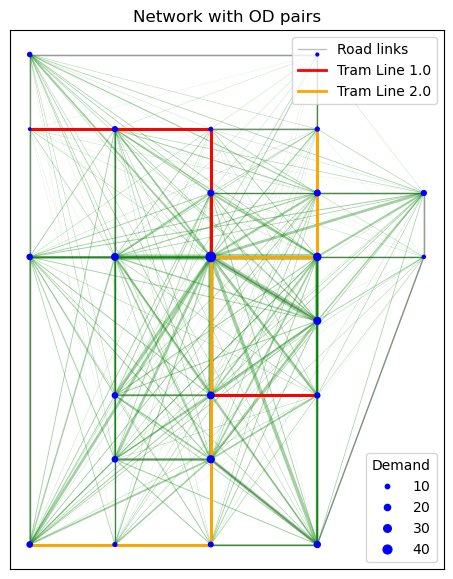

In [10]:
# load network
df_od = pd.read_csv('sf/sf_od.csv')
df_node = pd.read_csv('sf/sf_node.csv')
df_link = pd.read_csv('sf/sf_link.csv')
df_link_tram = pd.read_csv('sf/sf_link_tram.csv')

plot_network(df_node, df_link, df_link_tram, df_od)

In [12]:
# define cost function
def BPR_cost_function(df_link, x):
    return df_link.t0 * (1 + 0.15 * ((x/df_link.saturation)**4))

# define objective function
def Beckmann_obj_function(df_link, x):
    return (df_link.t0 * x * (1 + 0.03 * (x / df_link.saturation)**4)).sum()

In [107]:
# first run with recommended parameters
max_iter, max_gap, max_gap_ls = 100, 1e-4, 1e-2
x_star0, _, gap, obj = static_assignment_fw(df_od, df_link, df_link_tram, max_iter, max_gap, cost_function=BPR_cost_function, objective_function=Beckmann_obj_function)

print(f"Stopped after {len(gap)}/{max_iter} iterations, final gap : {gap[-1]}/{max_gap}, final obj value : {obj[-1]}")

Gap: 0.001458 - Objective: 42.3687: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]

Stopped after 100/100 iterations, final gap : 0.001701917420102655/0.0001, final obj value : 42.36810611841627


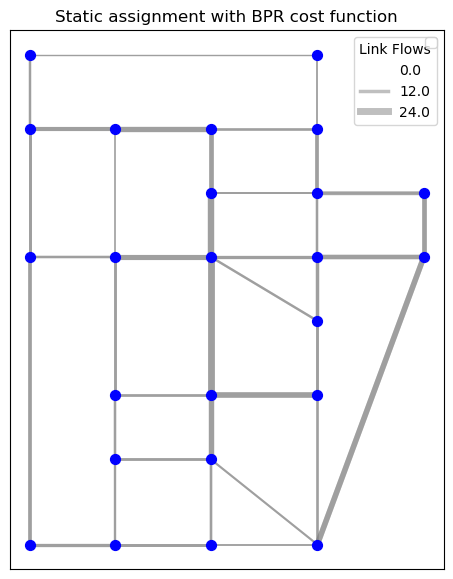

In [108]:
plot_network(df_node, df_link, link_flows=x_star0, title="Static assignment with BPR cost function")

In [109]:
# run with tram (level=1)
max_iter, max_gap, max_gap_ls = 100, 1e-4, 1e-2
x_star1, x_tram1, gap, obj = static_assignment_fw(df_od, df_link, df_link_tram, max_iter, max_gap, cost_function=BPR_cost_function, objective_function=Beckmann_obj_function, restriction_level=1)

print(f"Stopped after {len(gap)}/{max_iter} iterations, final gap : {gap[-1]}/{max_gap}, final obj value : {obj[-1]}")

Gap: 0.003032 - Objective: 30.0066:  11%|█         | 11/100 [00:13<01:49,  1.23s/it]

Stopped after 12/100 iterations, final gap : -0.002394080624504078/0.0001, final obj value : 30.00660629833346


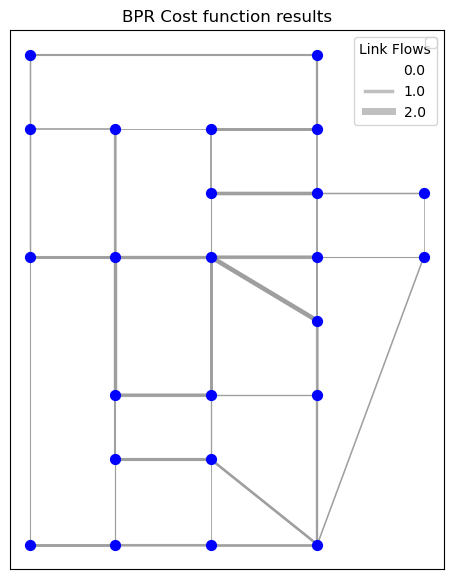

In [110]:
plot_network(df_node, df_link, link_flows=BPR_cost_function(df_link, x_star1).values*10, title="BPR Cost function results")


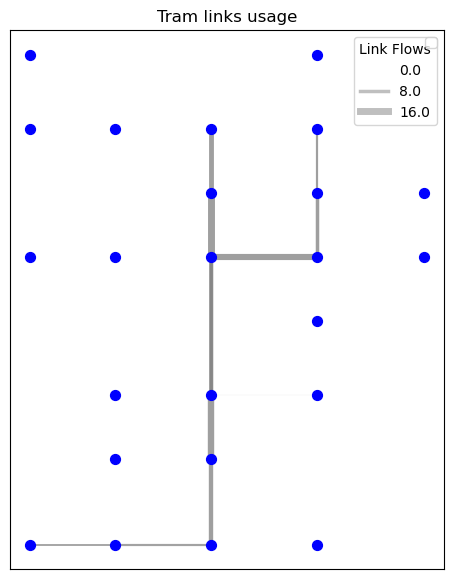

In [111]:
plot_network(df_node, df_link_tram, link_flows=x_tram1, title="Tram links usage")

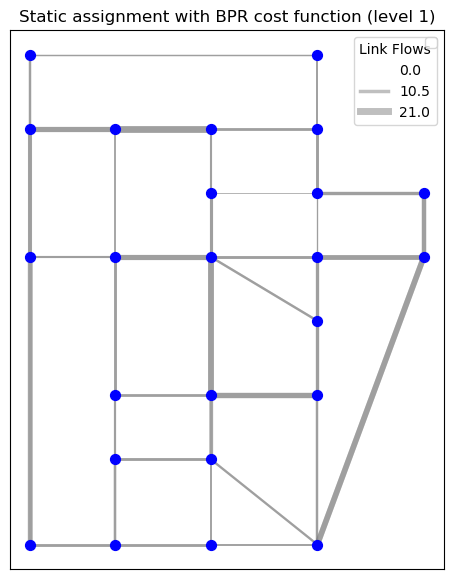

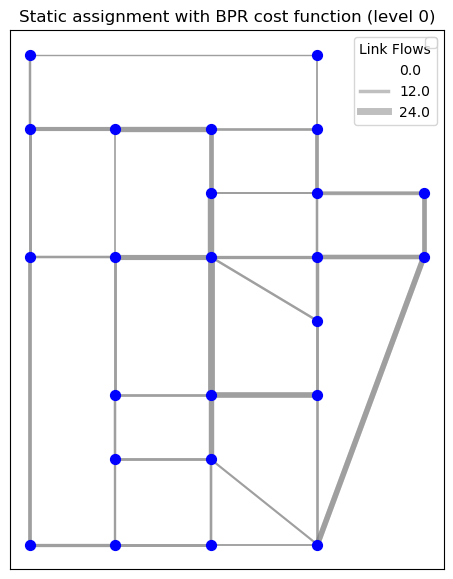

In [112]:
plot_network(df_node, df_link, link_flows=x_star1, title="Static assignment with BPR cost function (level 1)")
plot_network(df_node, df_link, link_flows=x_star0, title="Static assignment with BPR cost function (level 0)")

In [124]:
import matplotlib.pyplot as plt

(array([ 0.,  2.,  4.,  0.,  0.,  0., 10.,  6., 11.,  5.,  6., 23.,  9.]),
 array([-1.20000000e-01, -1.10000000e-01, -1.00000000e-01, -9.00000000e-02,
        -8.00000000e-02, -7.00000000e-02, -6.00000000e-02, -5.00000000e-02,
        -4.00000000e-02, -3.00000000e-02, -2.00000000e-02, -1.00000000e-02,
        -5.55111512e-17,  1.00000000e-02]),
 <BarContainer object of 13 artists>)

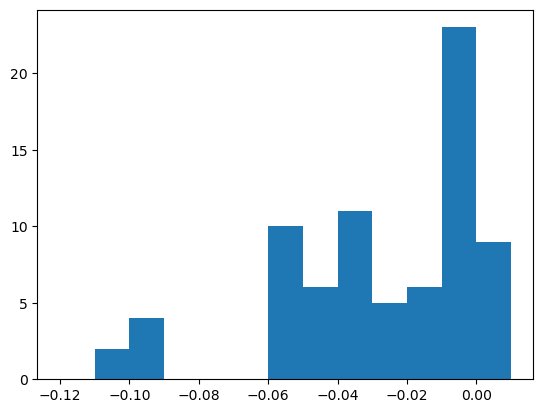

In [129]:
plt.hist(t1-t0, bins=np.arange(-0.12,.02,0.01))

In [135]:
# Separate the ODs between those that can use the tram and those that can not
restriction_level = 1
match restriction_level:
    case 0:
        mask = np.full(len(df_od), False)
    case 1:
        mask = df_od.dest.isin(df_link_tram.end_node) & df_od.org.isin(df_link_tram.start_node)
    case 2:
        mask = df_od.dest.isin(df_link_tram.end_node) | df_od.org.isin(df_link_tram.start_node)
    case _:
        raise ValueError(f"Unknown value {restriction_level} of `restriction_level`")
od_notram = df_od[~mask].reset_index(drop=True)
od_tram = df_od[mask].reset_index(drop=True)

od_notram

,od_id,org,dest,q
0,0,0,1,0.1
1,1,0,2,0.1
2,2,0,3,0.5
3,3,0,4,0.2
4,4,0,5,0.3
...,...,...,...,...
349,517,23,11,0.5
350,519,23,13,0.4
351,522,23,16,0.3
352,524,23,19,0.4


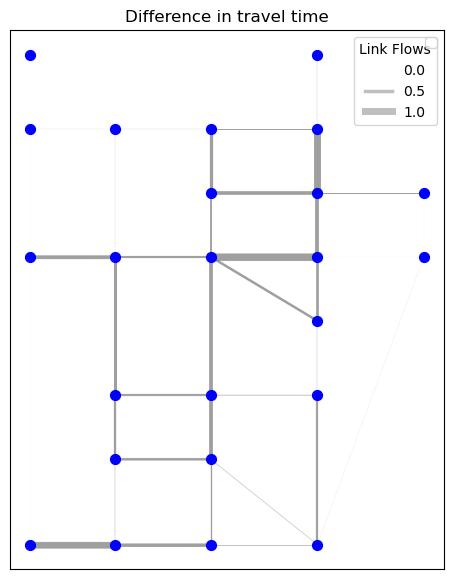

In [127]:
t0 = BPR_cost_function(df_link, x_star0).values
t1 = BPR_cost_function(df_link, x_star1).values
plot_network(df_node, df_link, link_flows=(t1-t0)*10, title="Difference in travel time")

distances: https://maps.app.goo.gl/8aV33hSoMT5dqdGJ6 (line 2)
https://maps.app.goo.gl/vfXk5ZgF1G3eepJu7 (line 1)

In [79]:
df_link_tram = pd.read_csv('sf/sf_link_tram.csv')
df_link_tram["time"] = df_link_tram["distance"] / 25 * 60# 25 miles/hour
df_link_tram["cost"] = df_link_tram["time"] / 60 #t_0 is in hours
df_link_tram.to_csv('sf/sf_link_tram.csv', index=False)

In [58]:
dijkstra?

Signature:     
dijkstra(
    csgraph,
    directed=True,
    indices=None,
    return_predecessors=False,
    unweighted=False,
    limit=inf,
    min_only=False,
)
Call signature: dijkstra(*args, **kwargs)
Type:           cython_function_or_method
String form:    <cyfunction dijkstra at 0x0000024763110110>
Docstring:     
dijkstra(csgraph, directed=True, indices=None, return_predecessors=False,
         unweighted=False, limit=np.inf, min_only=False)

Dijkstra algorithm using Fibonacci Heaps

.. versionadded:: 0.11.0

Parameters
----------
csgraph : array, matrix, or sparse matrix, 2 dimensions
    The N x N array of non-negative distances representing the input graph.
directed : bool, optional
    If True (default), then find the shortest path on a directed graph:
    only move from point i to point j along paths csgraph[i, j] and from
    point j to i along paths csgraph[j, i].
    If False, then find the shortest path on an undirected graph: the
    algorithm can progress from poi

In [ ]:
frankwolf

In [2]:
net = Network("SiouxFalls")

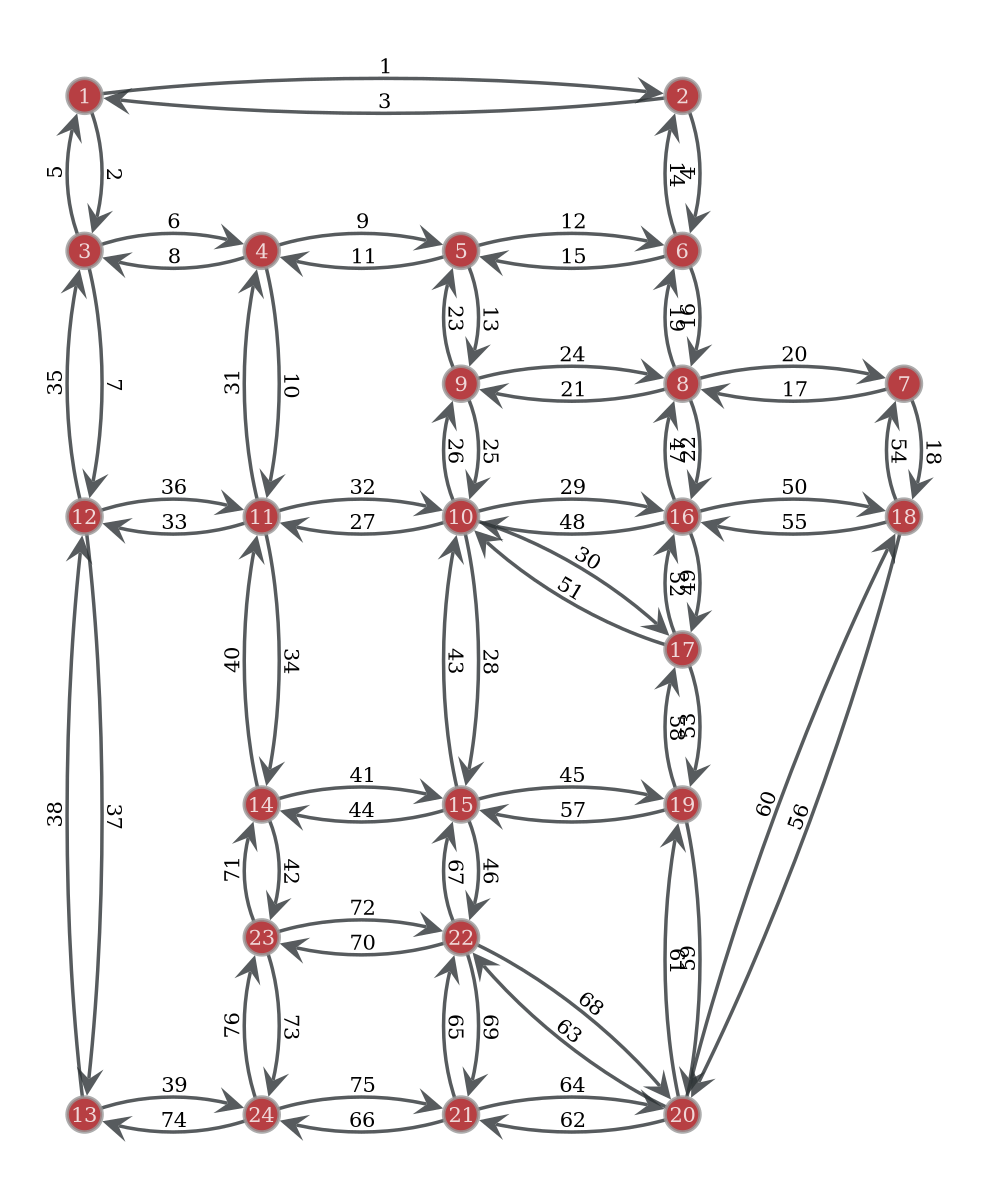

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0de0bb65d0, at 0x7f0d663c6c60>

In [3]:
net.draw()

In [4]:
initial_fw_by_o, initial_fw = frankwolf(net, net.trips, verbose=1)
net.save_flow(initial_fw_by_o, "initial_frankwolf_by_origin")
net.save_flow(initial_fw, "initial_frankwolf")

1104it [01:21, 13.59it/s, Relative error=9.95e-05]


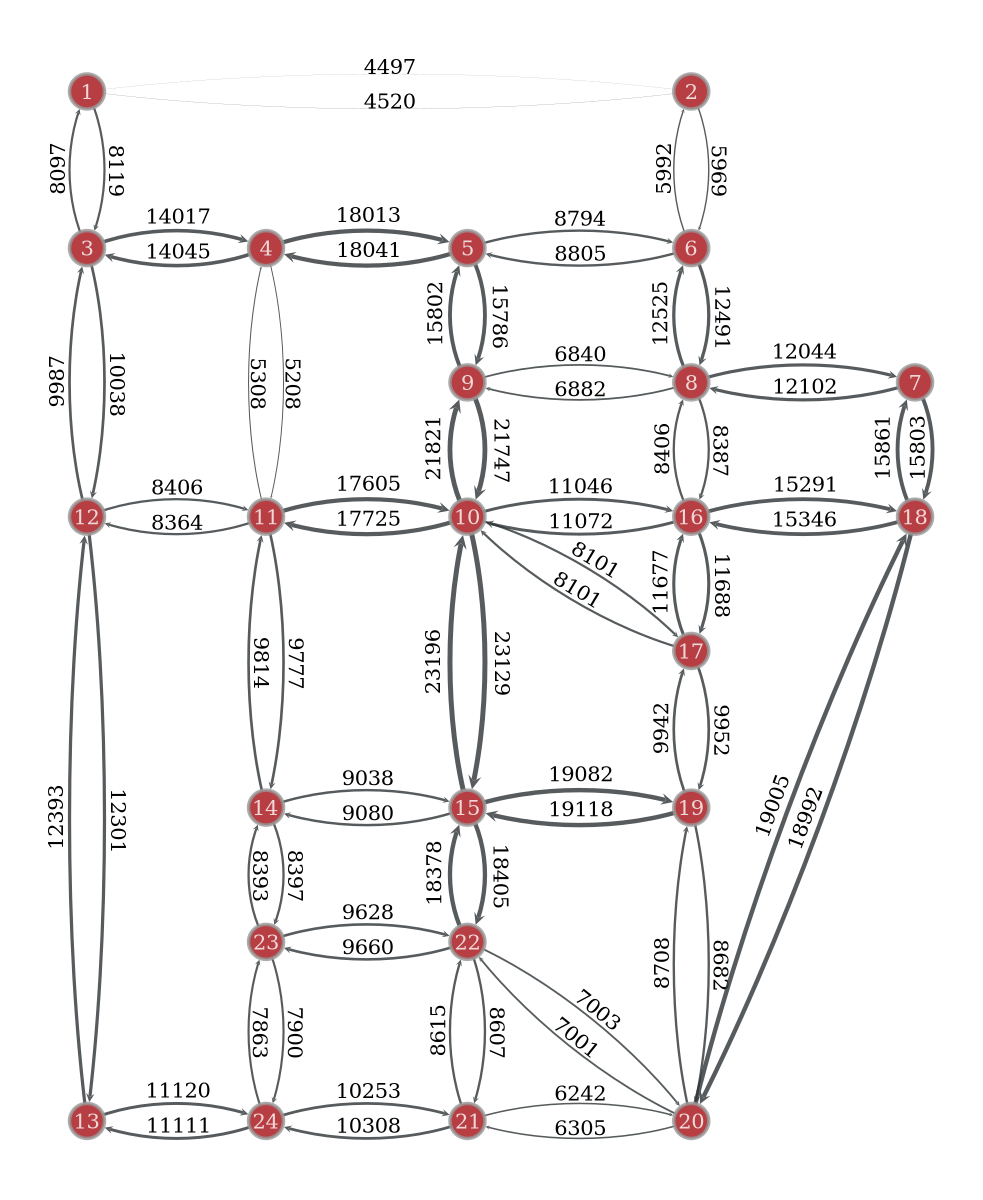

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0de0bb65d0, at 0x7f0d716d0860>

In [5]:
initial_fw = net.load_flow("initial_frankwolf")
net.draw(flows=initial_fw)

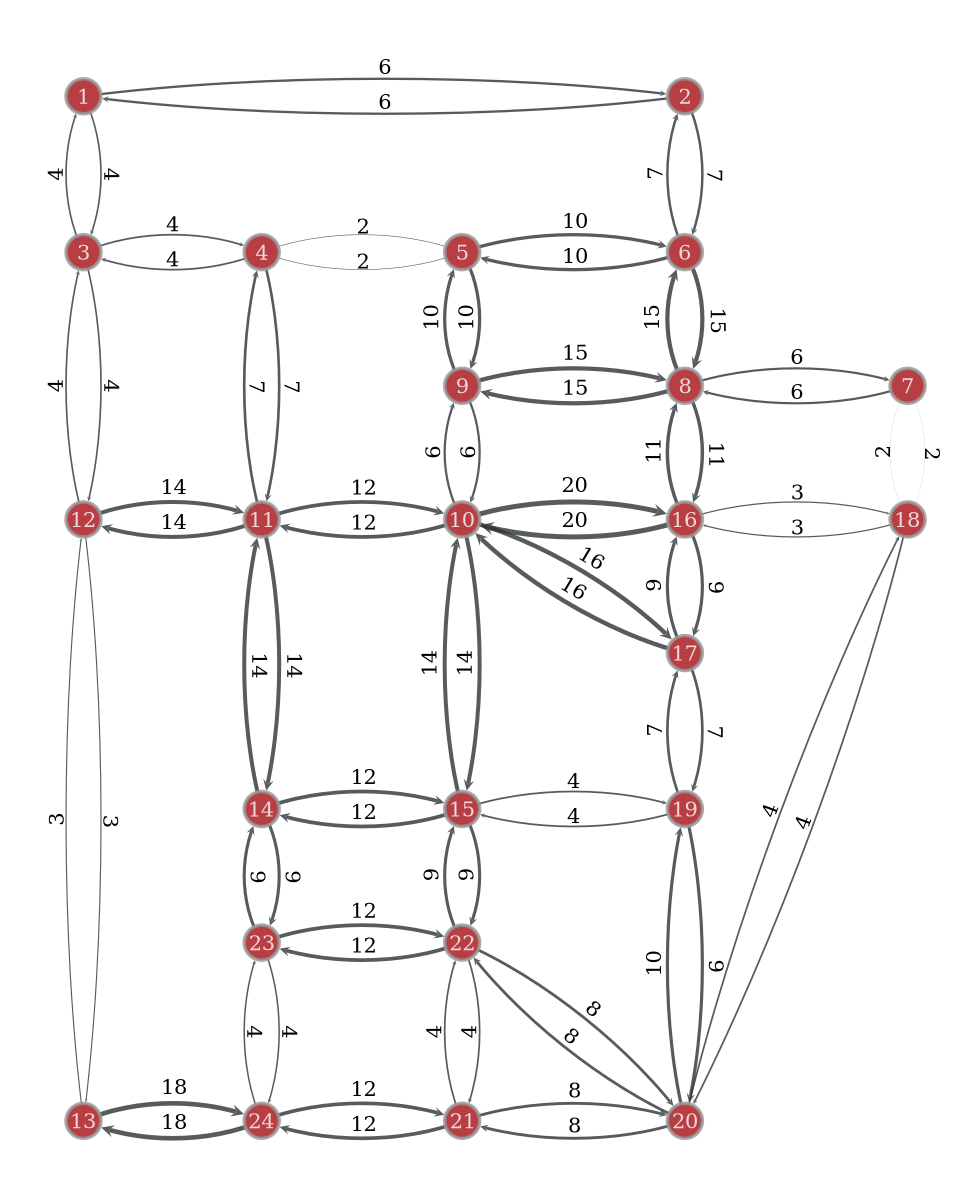

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0de0bb65d0, at 0x7f0d6be4d4c0>

In [6]:
times = BTR_cost_function(initial_fw, net)
net.draw(flows=times)

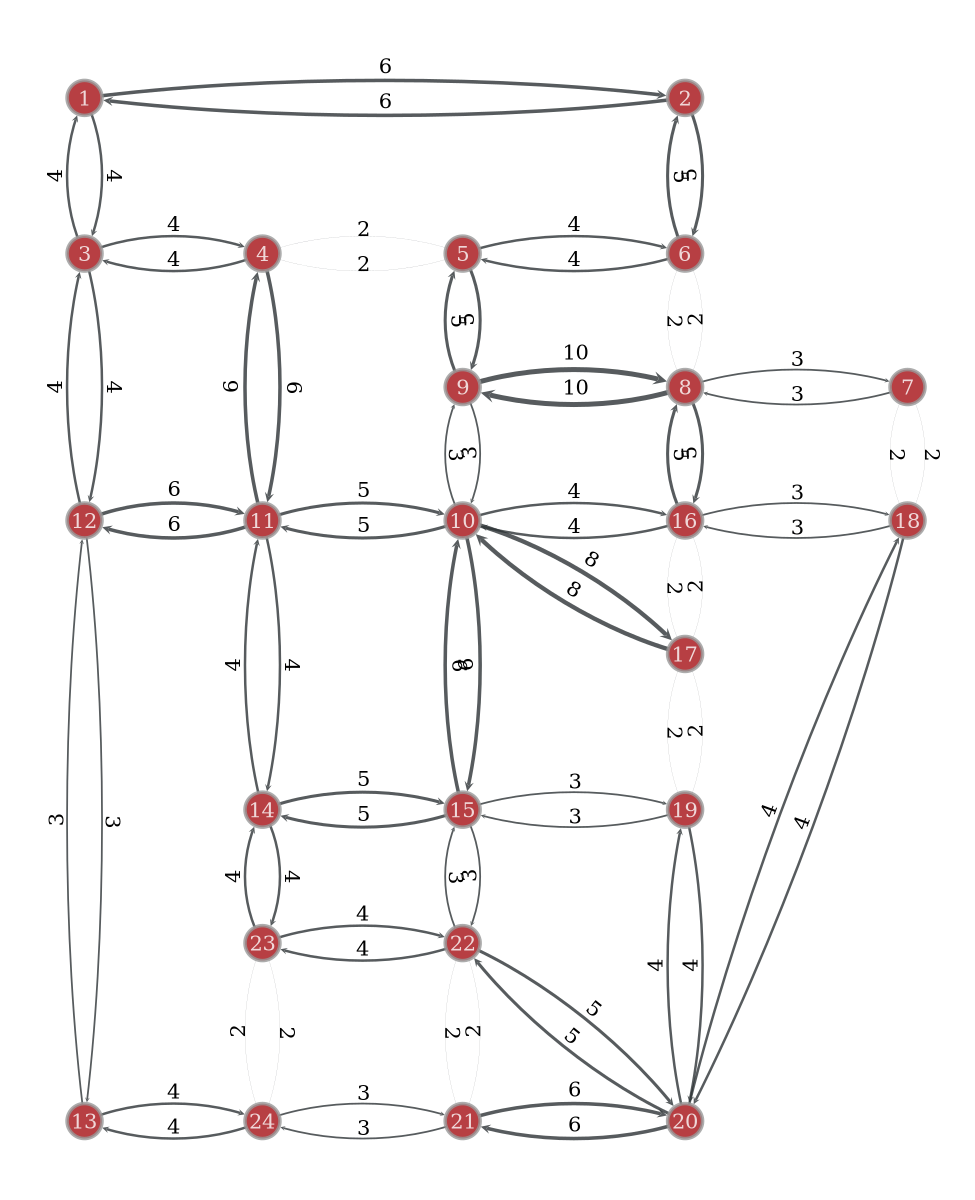

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0de0bb65d0, at 0x7f0d661947a0>

In [7]:
net.draw(flows = net.ep["length"])

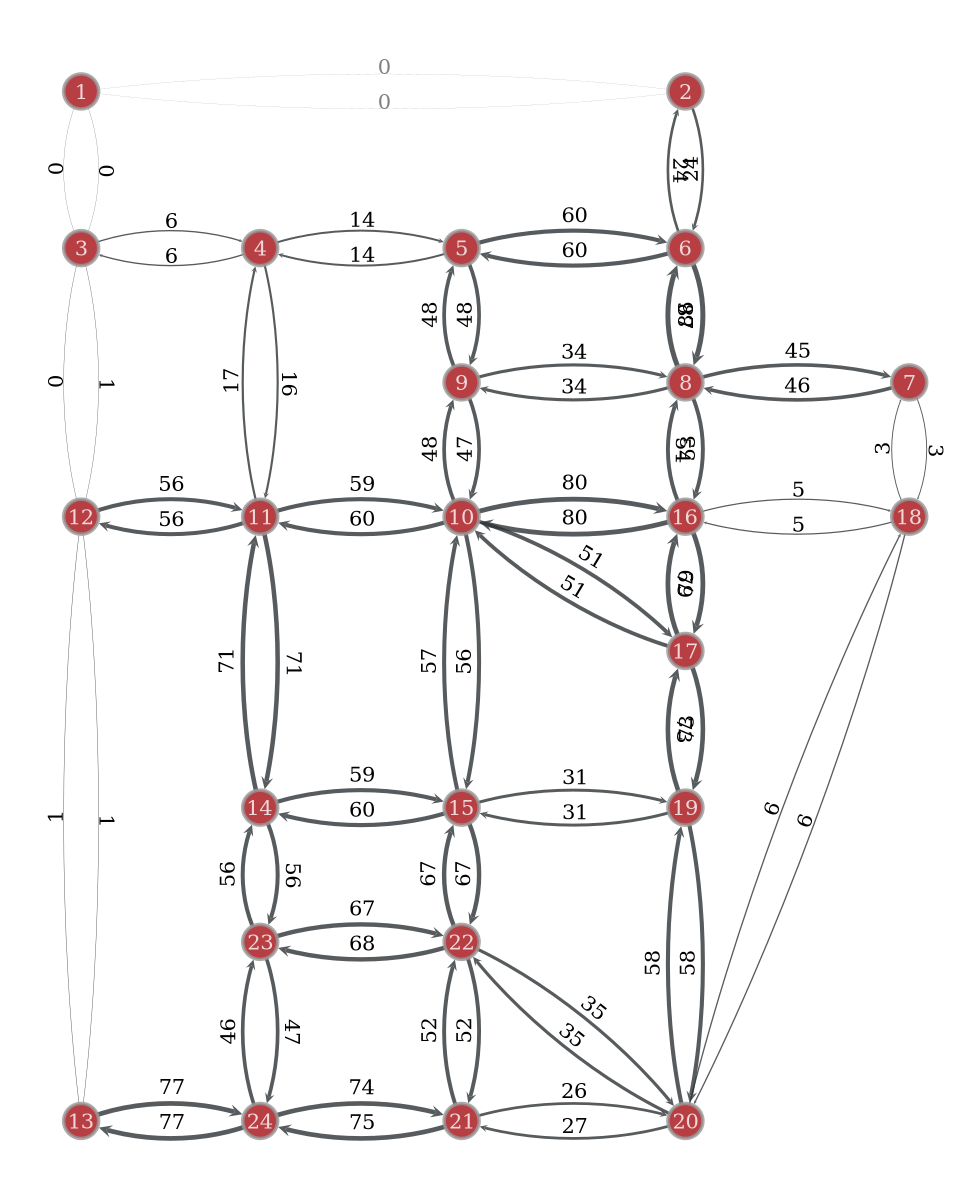

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0de0bb65d0, at 0x7f0d6e84c4a0>

In [8]:
diff_times = times.copy()
diff_times.a = (times.a - net.ep["free_flow_time"].a) / times.a *100
net.draw(flows=diff_times)